# Vanilla Policy Gradient (VPG)

Using the advantage somewhat **centers scores around zero**. Better-than-average actions have a positive score (increasing probabilities), worse-than-average have a negative score (decreasing probabilities).

First of all we implement a parametric policy as a neural network as in REINFORCE, the only difference is that now the select_action function calculates also the entropy term:

In [4]:
import torch

class PolicyApproximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyApproximator, self).__init__()

        # define the activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # defining the input layer
        self.input_layer = torch.nn.Linear(state_size, 512)

        # creating the hidden layers 
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(512, 128))
        
        # connecting the output layer    
        self.output_layer = torch.nn.Linear(128, action_size)
        
    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # finally, pass for the output layer
        preferences = self.output_layer(x)

        return preferences
    
    def select_action(self, state):

        # get the preferences over actions
        preferences = self.forward(state)

        # sample the action from the probability distribution
        dist = torch.distributions.Categorical(logits=preferences)
        action = dist.sample()

        # calculate the log probability of the actions, it is needed for the loss
        logpa = dist.log_prob(action).unsqueeze(-1)

        # calculate the entropy
        entropy = dist.entropy().unsqueeze(-1)

        return action.item(), logpa, entropy
    
    def select_greedy_action(self, state):
        
        # we select the action with the highest preference
        preferences = self.forward(state)
        action = np.argmax(preferences.detach().numpy())
        
        return action
    

We need a new neural network to approximate the state-value function:

In [5]:
class ValueApproximator(torch.nn.Module):
    def __init__(self, state_size):
        super(ValueApproximator, self).__init__()

        # define the activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # defining the input layer
        self.input_layer = torch.nn.Linear(state_size, 512)

        # creating the hidden layers 
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(512, 128))
        
        # connecting the output layer    
        self.output_layer = torch.nn.Linear(128, 1)
        
    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # finally, pass for the output layer
        value = self.output_layer(x)

        return value

We write the optimization method in order to calculate the loss and make a step of gradient descent. The loss is calculated as the log probability of the actions selected weighted by the returns obtained after that action was selected. 

In [17]:
def optimize(policy_model, value_model, rewards, logpas, values, entropies, policy_optimizer, value_optimizer, gamma):
    
    T = len(rewards)
    
    # calculate all discounts (as with all Monte Carlo methods)
    discounts = np.logspace(0, T, num=T, base=gamma, endpoint=False)

    # calculate the sum of discounted returns for all time steps
    # notice this is the returns for every time step in the episode,
    # from the initial state at time step 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    # remove the extra elements and format the variables as expected
    returns = torch.FloatTensor(returns)
    
    # prepare the log probabilities, the entropies and tge values
    logpas = torch.cat(logpas)
    entropies = torch.cat(entropies) 
    values = torch.cat(values)

    # calculate the value error
    value_error = returns - values
 
    # calculate the policy loss
    beta = 0.001
    policy_loss_logpas = -(value_error.detach() * logpas).mean()
    policy_loss_entropies = -entropies.mean()
    policy_loss = policy_loss_logpas + beta * policy_loss_entropies

    # calculate the value loss
    value_loss = (returns - values).pow(2).mean()
        
    # optimize the policy network
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    # optimize the value-function network
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

The evaluation methos is the same as in REINFORCE.

In [7]:
def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = approximator.select_greedy_action(state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

Finally, we can write the complete algorithm, similar to REINFORCE, but with the addition of the value network and the entropy term:

In [14]:
import time
import numpy as np
import random
from itertools import count

import gymnasium

def vpg(env_name, seed, gamma, max_time, max_episodes, max_score, episodes_window):

    # create the environment
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the policy model and its optimizer
    policy_model = PolicyApproximator(state_size, action_size)
    policy_optimizer = torch.optim.RMSprop(policy_model.parameters(), lr=0.0005)

    # create the value model and its optimizer
    value_model = ValueApproximator(state_size)
    value_optimizer = torch.optim.RMSprop(value_model.parameters(), lr=0.0005)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = [] 

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan
        
    # train until we reach a terminal condition
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()
        
        # set return to 0
        discounted_return = 0
        
        # reset the environment before starting the episode
        state = env.reset()[0]
        
        # interact with the environment until the episode is done
        logpas = []
        rewards = []
        entropies = []
        values = []
        
        for step in count():
    
            # select the action using the policy
            action, logpa, entropy = policy_model.select_action(state)

            # collect an experience tuple as usual 
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated
    
            # save the log probability, entropy, reward and value
            logpas.append(logpa)
            entropies.append(entropy)
            rewards.append(reward)
            values.append(value_model(state))

            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
            
            if is_done: 
                break

        # then, run one optimization step
        optimize(policy_model, value_model, rewards, logpas, values, entropies, policy_optimizer, value_optimizer, gamma)

        # evaluate the learned policy after the episode
        score = evaluate(policy_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        total_step += step
        training_time += episode_elapsed  

        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time

        # informative print logging  
        message = 'episode {:04}, steps {:06}, average score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)

        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break
    
    return policy_model, score, results

We can run VPG in the cart-pole environment so that we can easily compare it and REINFORCE 

In [15]:
import gymnasium

def run_experiment(env_name, algorithm, gamma, seeds, 
                   max_time, max_episodes, max_score, episodes_window):

    # variables to collect results
    results = []
    best_agent = None
    best_eval_score = float('-inf')
    
    for seed in seeds:
        # create the agent
        agent, score, result = algorithm(env_name, seed, gamma, 
                                         max_time, max_episodes, max_score, episodes_window)

        # save the results the best agent
        results.append(result)
        if score > best_eval_score:
            best_eval_score = score
            best_agent = agent
        
    return results, best_agent, best_eval_score

In [18]:
vpg_results, vpg_agent, vpg_score = run_experiment(
env_name = 'CartPole-v1',
algorithm = vpg, 
seeds = (15, 39, 12, 45, 65),
gamma = 0.99,
max_episodes = 1500,
max_time = 60*3,
max_score = 450,
episodes_window = 50)

episode 0234, steps 047455, average score 452.5  --> reached_max_score 
episode 0208, steps 047350, average score 452.1  --> reached_max_score 
episode 0208, steps 043332, average score 452.2  --> reached_max_score 
episode 0182, steps 030947, average score 450.7  --> reached_max_score 
episode 0213, steps 041614, average score 451.3  --> reached_max_score 


We can save the result to future comparison:

In [19]:
np.save('./saved/vpg_results', vpg_results)

We can load the result of DQN in order to compare the performances of the two algorithms:

In [20]:
reinforce_results = np.load('./saved/reinforce_results.npy')

We can plot the training reward:

In [21]:
import matplotlib.pyplot as plt

def show_result(what, alg_a_name, alg_a_results, alg_b_name, alg_b_results):

    plt.figure(figsize=(12,6))
    
    # steps, train_reward,  eval_score,  time
    alg_a_max  = np.max(alg_a_results, axis=0).T
    alg_a_min  = np.min(alg_a_results, axis=0).T
    alg_a_mean = np.mean(alg_a_results, axis=0).T
    alg_a_episodes = np.arange(len(alg_a_mean[0]))

    alg_b_max  = np.max(alg_b_results, axis=0).T
    alg_b_min  = np.min(alg_b_results, axis=0).T
    alg_b_mean = np.mean(alg_b_results, axis=0).T
    alg_b_episodes = np.arange(len(alg_b_mean[0]))

    if (what == 'total_steps'):
        index = 0;
        title = 'Total Steps'
        label = 'Steps'
    elif(what == 'avg_training_reward'):
        index = 1;
        title = 'Moving Avg Reward (Training)'
        label = 'Reward'
    elif(what == 'avg_evaluation_reward'):
        index = 2;
        title = 'Moving Avg Reward (Evaluation)'
        label = 'Reward'
    elif(what == 'training_time'):
        index = 3;
        title = 'Trainning time)'
        label = 'Time'
    else:
        raise ValueError('Not sure what you want to plot')

    plt.plot(alg_a_max[index], 'b', linewidth=1, label=alg_a_name)
    plt.plot(alg_a_min[index], 'b', linewidth=1)
    plt.plot(alg_a_mean[index], 'b', linewidth=1)
    plt.fill_between(alg_a_episodes, alg_a_min[index], alg_a_max[index], facecolor='b', alpha=0.3)

    plt.plot(alg_b_max[index], 'g', linewidth=1, label=alg_b_name)
    plt.plot(alg_b_min[index], 'g', linewidth=1)
    plt.plot(alg_b_mean[index], 'g', linewidth=1)
    plt.fill_between(alg_b_episodes, alg_b_min[index], alg_b_max[index], facecolor='g', alpha=0.3)

    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Episodes')
    plt.legend()

    plt.show()

The REINFORCE algorithm works in simple problems, and it has convergence guarantees. But because it uses the full Monte Carlo returns for calculating the gradient, its variance is a problem. The accumulation of random events along a trajectory (including the initial state) and the randomness associated with the stochastic policy is compounded inside the return, making it a high-variance signal that's challenging to interpret.

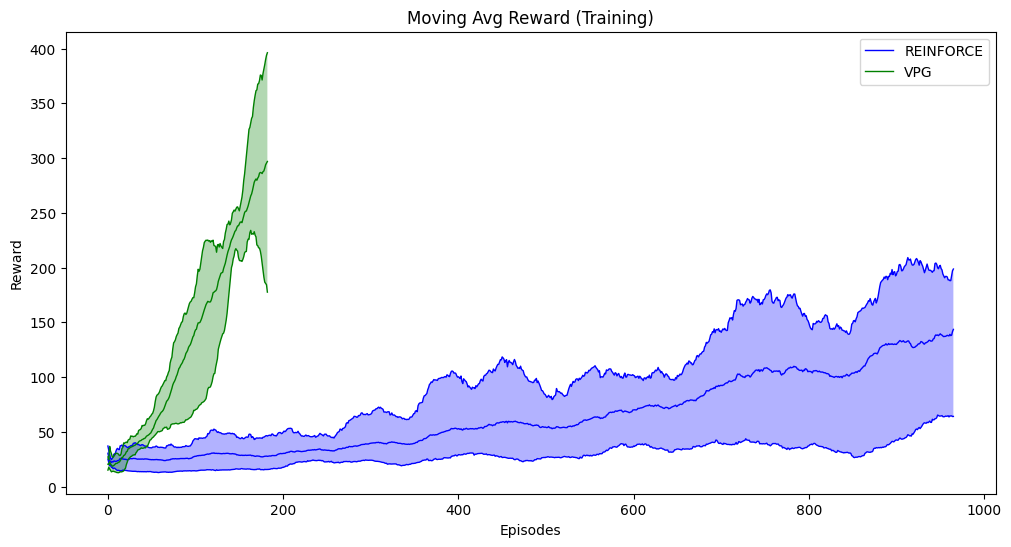

In [22]:
show_result('avg_training_reward','REINFORCE', reinforce_results, 'VPG', vpg_results) 

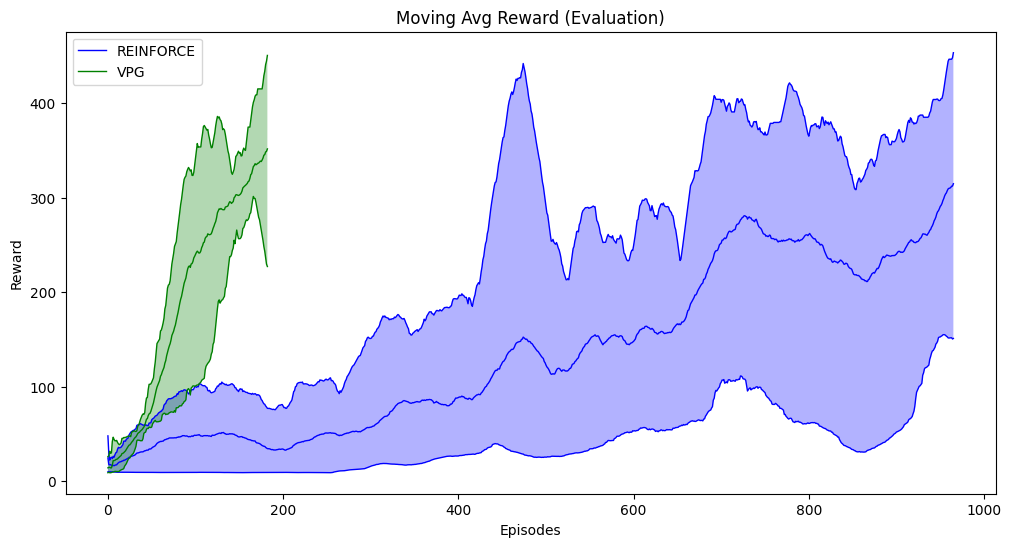

In [23]:
show_result('avg_evaluation_reward','REINFORCE', reinforce_results, 'VPG', vpg_results) 

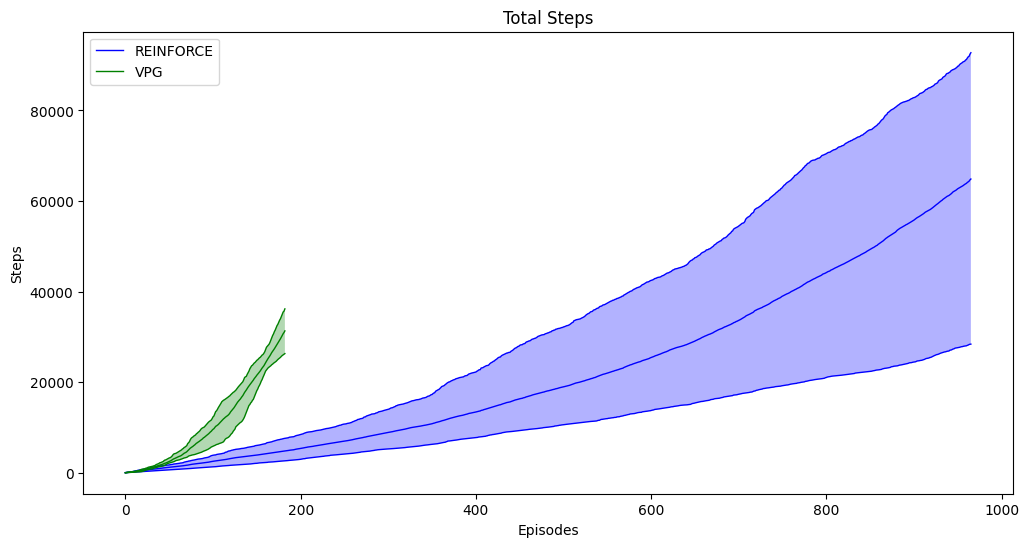

In [24]:
show_result('total_steps','REINFORCE', reinforce_results, 'VPG', vpg_results) 

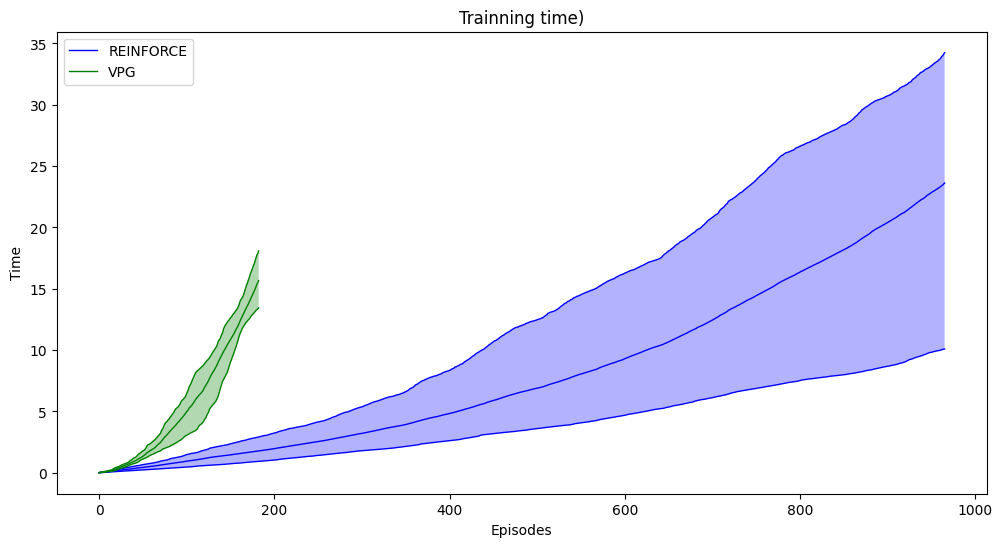

In [25]:
show_result('training_time','REINFORCE', reinforce_results, 'VPG', vpg_results) 

VPG is a pretty robust method for simple problems; it is, for the most part, unbiased because it uses an unbiased target for learning both the policy and value function. That is, it uses Monte Carlo returns, which are complete actual returns experienced directly in the environment, without any bootstrapping. The only bias in the entire algorithm is because we use function approximation, which is inherently biased.